# 01_Train_RESNET_50

### Imports

In [1]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.models as models
import torch 

from sklearn.metrics import f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm


### Use GPU

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Plot sample

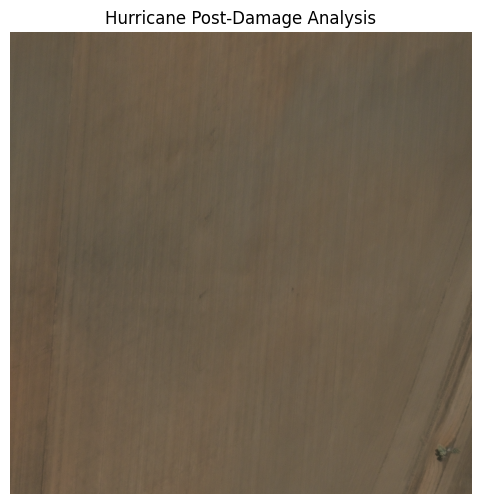

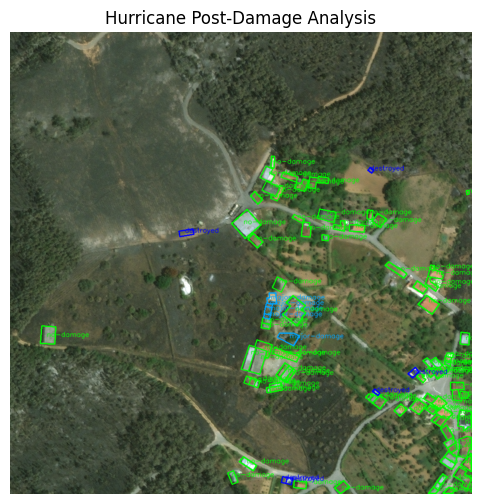

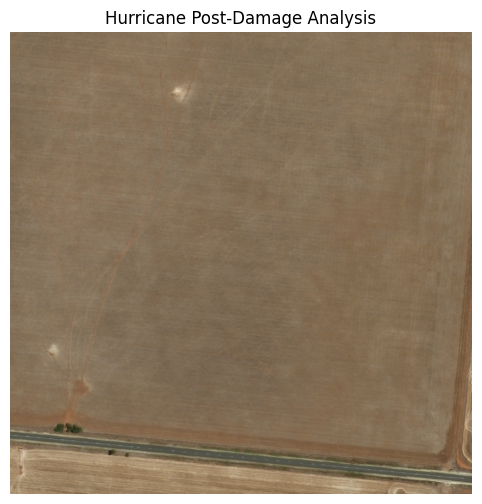

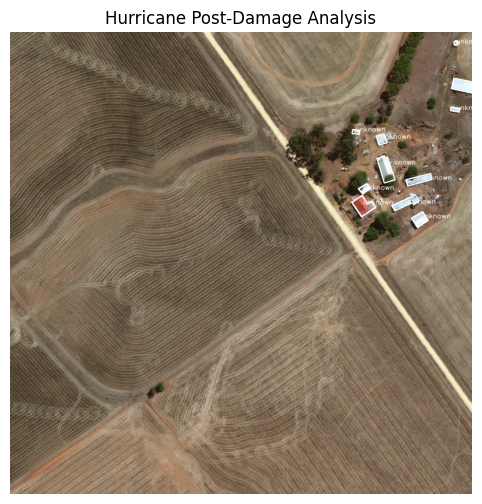

In [3]:
json_dir = os.path.join(os.getcwd(), "../data/raw/tier3/labels")
image_dir = os.path.join(os.getcwd(), "../data/raw/tier3/images")

damage_colors = {
    "no-damage": (0, 255, 0),      
    "minor-damage": (255, 255, 0), 
    "major-damage": (255, 165, 0), 
    "destroyed": (255, 0, 0)       
}

def extract_polygons(max_images=4):
    if not os.path.exists(json_dir):
        print(f"Error: Label folder not found at {json_dir}")
        return

    count = 0
    for json_file in os.listdir(json_dir):
        if not json_file.endswith(".json"):
            continue

        json_path = os.path.join(json_dir, json_file)
        with open(json_path, "r") as f:
            data = json.load(f)

        image_name = data.get("metadata", {}).get("img_name")
        if not image_name:
            print(f"Warning: 'img_name' missing in {json_file}, skipping.")
            continue

        image_path = os.path.join(image_dir, image_name)
        image = cv2.imread(image_path)
        if image is None:
            print(f"Could not load image: {image_path}")
            continue

        for building in data.get("features", {}).get("xy", []):
            wkt_string = building.get("wkt", "")
            if not wkt_string.startswith("POLYGON (("):
                continue

            coords = wkt_string[10:-2].split(", ")
            polygon = np.array([list(map(float, coord.split())) for coord in coords])

            label = building.get("properties", {}).get("subtype", "unknown")
            color = damage_colors.get(label, (255, 255, 255))

            pts = polygon.reshape((-1, 1, 2)).astype(np.int32)
            cv2.polylines(image, [pts], isClosed=True, color=color, thickness=2)

            if len(polygon) > 0:
                centroid = np.mean(polygon, axis=0).astype(int)
                cv2.putText(image, label, tuple(centroid), cv2.FONT_HERSHEY_SIMPLEX,
                            0.5, color, 1, cv2.LINE_AA)

        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title(f"Hurricane Post-Damage Analysis")
        plt.axis("off")
        plt.show()

        count += 1
        if count >= max_images:
            break

extract_polygons(max_images=4)

### Data Loader

In [ ]:
damage_classes = {
    "no-damage": 0,
    "minor-damage": 1,
    "major-damage": 2,
    "destroyed": 3
}

class DisasterDataset(Dataset):
    def __init__(self, transform=None):
        """Dataset for extracting post-disaster building images and labels."""
        self.image_dir = os.path.join(os.getcwd(), "../data/raw/tier3/images")
        self.json_dir = os.path.join(os.getcwd(), "../data/raw/tier3/labels")
        self.transform = transform
        self.samples = []

        print("🔄 Loading dataset...")
        self._load_data()
        print(f"Dataset loaded: {len(self.samples)} samples found.")

    def _load_data(self):
        """Loads image paths, polygons, and labels from the dataset."""
        if not os.path.exists(self.json_dir):
            print(f"Label directory not found: {self.json_dir}")
            return

        image_building_count = {}  

        for json_file in os.listdir(self.json_dir):
            if not json_file.endswith(".json"):
                continue
            
            if 'post' not in json_file:
                continue

            json_path = os.path.join(self.json_dir, json_file)
            with open(json_path, "r") as f:
                data = json.load(f)

            image_name = data["metadata"].get("img_name")
            if image_name is None:
                print(f"Warning: 'img_name' missing in {json_file}, skipping.")
                continue

            image_path = os.path.join(self.image_dir, image_name)
            if not os.path.exists(image_path):
                print(f"Missing image: {image_path}, skipping.")
                continue

            building_count = 0 

            for building in data["features"]["xy"]:
                wkt_string = building["wkt"]
                if not wkt_string.startswith("POLYGON (("):
                    continue

                coords = wkt_string[10:-2].split(", ")
                polygon = np.array([list(map(float, coord.split())) for coord in coords])

                print(building)
                label = building["properties"]["subtype"]
                uid = building["properties"].get("uid") 
                if label not in damage_classes:
                    continue

                self.samples.append((image_path, polygon, damage_classes[label],uid))
                building_count += 1
            image_building_count[image_name] = building_count

        print("\nNumber of extracted buildings per image (first 10):")
        for i, (image_name, count) in enumerate(image_building_count.items()):
            print(f"{i + 1}. {image_name}: {count} buildings")
            if i == 20:  
                break

    def __len__(self):
        return len(self.samples)

    def _crop_building(self, image, polygon):
        """Extracts a cropped building image from the full image."""
        x_min, y_min = polygon.min(axis=0).astype(int)
        x_max, y_max = polygon.max(axis=0).astype(int)

        cropped = image[y_min:y_max, x_min:x_max]
        return cropped

    def __getitem__(self, idx):
        """Retrieves a (cropped building image, label, image_name, uid) pair."""
        image_path, polygon, label,uid= self.samples[idx]  
        image_name = os.path.basename(image_path) 
        
        image = cv2.imread(image_path)
        if image is None:
            print(f"Could not read image: {image_path}, skipping.")
            return None

        cropped = self._crop_building(image, polygon)

        if cropped.shape[0] == 0 or cropped.shape[1] == 0:
            print(f"Skipping empty crop in {image_path}")
            return None

        cropped = cv2.resize(cropped, (224, 224))
        cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)
        cropped = torch.tensor(cropped, dtype=torch.float32).permute(2, 0, 1) / 255.0

        if self.transform:
            cropped = self.transform(cropped)

        return cropped, label, image_name,uid

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Zoom
    transforms.RandomHorizontalFlip(),  # Flip 
    transforms.RandomRotation(20),  # Rotate 
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2), 
    transforms.ToTensor(), # Color var
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # normalization
])

print("Initializing dataset...")
dataset = DisasterDataset(transform=transform)

dataset.samples = [sample for sample in dataset.samples if sample is not None]

print("Creating DataLoader...")
dataloader = DataLoader(dataset, batch_size=100, shuffle=True, num_workers=13)

In [ ]:
print(f"Dataset sample: {dataset[0]}")  

### Model

In [ ]:
class ImprovedDamageClassifier(nn.Module):
    def __init__(self, num_classes=4, dropout_prob=0.5):
        super(ImprovedDamageClassifier, self).__init__()

        self.resnet = models.resnet50(pretrained=True)
        self.resnet = nn.Sequential(*list(self.resnet.children())[:-1]) 

        for param in self.resnet.parameters():
            param.requires_grad = False
            
        for layer in list(self.resnet.children())[-3:]:  #ici unfreeze
            for param in layer.parameters():
                param.requires_grad = True

        self.fc1 = nn.Linear(2048, 1024)
        self.bn1 = nn.BatchNorm1d(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc3 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1) 

        x = self.fc1(x)
        x = self.bn1(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.bn2(x)
        x = nn.ReLU()(x)
        x = self.dropout(x)

        x = self.fc3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedDamageClassifier(num_classes=4).to(device)

save_path = os.path.join(os.getcwd(), 'checkpoints/improved_model.pth')

os.makedirs(os.path.dirname(save_path), exist_ok=True)

torch.save(model.state_dict(), save_path)
print(f"Model saved successfully at: {save_path}")

### Train the model

In [ ]:
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = dataset_size - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=100, shuffle=False)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)  
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5) 
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

num_epochs = 50

for epoch in tqdm(range(num_epochs)):
    print(f"\nEpoch {epoch+1}/{num_epochs} starting...")

    # Training phase
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []

    for batch_idx, (images, labels,image_names, uids) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

        if (batch_idx + 1) % 10 == 0 or batch_idx == 0:
            batch_f1 = f1_score(all_labels, all_preds, average="macro")
            print(f"Batch {batch_idx+1}/{len(train_loader)} - Loss: {loss.item():.4f}, F1: {batch_f1:.4f}")

    train_f1 = f1_score(all_labels, all_preds, average="macro")
    print(f"\nEpoch {epoch+1} Training Done - Avg Loss: {total_loss/len(train_loader):.4f}, F1: {train_f1:.4f}")

    model.eval()
    val_loss = 0
    val_preds, val_labels = [], []
    image_names, building_uids = [], []  

    with torch.no_grad():
        for batch_idx, (images, labels, img_names, uids) in enumerate(val_loader):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            val_preds.extend(preds)
            val_labels.extend(labels.cpu().numpy())
            image_names.extend(img_names)  
            building_uids.extend(uids) 

            if (batch_idx + 1) % 5 == 0 or batch_idx == 0:
                batch_f1 = f1_score(val_labels, val_preds, average="macro")
                print(f"🔵 Validation Batch {batch_idx+1}/{len(val_loader)} - Loss: {loss.item():.4f}, F1: {batch_f1:.4f}")

    val_f1 = f1_score(val_labels, val_preds, average="macro")
    print(f"\nEpoch {epoch+1} Summary - Train Loss: {total_loss/len(train_loader):.4f}, Train F1: {train_f1:.4f}, Val Loss: {val_loss/len(val_loader):.4f}, Val F1: {val_f1:.4f}")

print("\nTraining complete!")

### Save predictions

In [ ]:
val_predictions_df = pd.DataFrame({
    'Image Name': image_names,
    'Building UID': building_uids,
    'True Labels': val_labels,
    'Predicted Labels': val_preds
})

val_predictions_df.to_csv('val_predictions3.csv', index=False)
print("Predictions saved successfully !")

In [ ]:
class_report = classification_report(val_labels, val_preds, digits=4)
print("\nClassification Report:\n", class_report)

final_f1_macro = f1_score(val_labels, val_preds, average="macro")
print(f"\nFinal Macro F1 Score: {final_f1_macro:.4f}")

### Confusion Matrix

In [ ]:
cm = confusion_matrix(val_labels, val_preds)

plt.figure(figsize=(16, 11))
cmd = ConfusionMatrixDisplay(cm, display_labels=['No Damage', 'Minor Damage', 'Major Damage', 'Destroyed'])
cmd.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()